# Sectora Horizon
---
A Future-Focused Analytics System for Industries and Busisness.

In [2]:
from ingest.catalog import DatasetCatalog
from ingest.loader import RawDatasetLoader
from utils.uuid import generate_deterministic_id_name_based
from utils.clean import clean_text, is_numeric_string, normalize_code_to_length, normalize_text
from ingest.fetch.csv import CsvAdapter
from ingest.fetch.sct import SocrataAdapter
from ingest.fetch.excel import ExcelAdapter
import pandas as pd
import numpy as np
catalog = DatasetCatalog()
loader = RawDatasetLoader(
    csv_adapter=CsvAdapter(),
    sct_adapter=SocrataAdapter(),
    excel_adapter=ExcelAdapter(),
)

In [3]:
ds = catalog.get("master_csv")
records = list(loader.load(ds))
df = pd.DataFrame(records)

In [4]:
# El CSV debe tener columnas: 'year' y 'CPI' (índice anual)
cpi_ds = catalog.get("IPCanal")
records = list(loader.load(cpi_ds))
cpi = pd.DataFrame(records)
cpi

# normalizar nombres de columnas comunes
if 'Año de Corte'  in cpi.columns and 'year' not in cpi.columns:
    cpi = cpi.rename(columns={'Año de Corte':'year'})
if 'CPI' not in cpi.columns:
    # intentar detectar la columna de índice de precios
    possible = [c for c in cpi.columns if 'cpi' in c.lower() or 'ipc' in c.lower() or 'indice' in c.lower()]
    if possible:
        cpi = cpi.rename(columns={possible[0]:'CPI'})
cpi.columns = cpi.columns.map(lambda x: x.encode('utf-8').decode('utf-8-sig').strip())
print('CPI columns:', cpi.columns.tolist())


CPI columns: ['year', 'CPI']


In [5]:
# Asegurarnos de tener columna 'Año de Corte' en cpi
if 'year' not in cpi.columns:
    if 'Año de Corte' in cpi.columns:
        cpi = cpi.rename(columns={'Año de Corte':'year'})
    else:
        # intentar detectar columna con años (4 dígitos)
        for col in cpi.columns:
            sample = cpi[col].astype(str).str.extract(r'(\d{4})', expand=False)
            if sample.dropna().shape[0] > 0:
                cpi = cpi.rename(columns={col:'year'})
                
                break

# Convertir ambos a numérico entero (manejar strings, espacios, comas, separadores de miles)
# Limpiar: eliminar cualquier caracter no numérico, luego convertir a número

def clean_year_series(s):
    s2 = s.astype(str).str.strip().replace({'': pd.NA})
    # eliminar todo lo que no sea dígito
    s2 = s2.str.replace(r'[^0-9]', '', regex=True)
    # si quedó vacío, convertir a NA
    s2 = s2.replace('', pd.NA)
    return pd.to_numeric(s2, errors='coerce').astype('Int64')

# Aplicar limpieza
if 'year' in df.columns:
    df['year'] = clean_year_series(df['year'])
else:
    raise KeyError("La columna 'year' no existe en df")

cpi['year'] = clean_year_series(cpi['year'])

print("df Año de Corte dtype (normalizado):", df['year'].dtype)
print("CPI Año de Corte dtype (normalizado):", cpi['year'].dtype)
print("Años en CPI:", sorted(cpi['year'].dropna().unique()))

# Identificar filas que no pudieron convertirse (muestra algunas muestras para diagnóstico)
bad_df_years = df[df['year'].isna()].head(10)
print("Filas df con year inválido:", df['year'].isna().sum())
if not bad_df_years.empty:
    print("Ejemplos (valores originales):")
    print(bad_df_years.head(10))
print("Filas cpi con Año de Corte inválido:", cpi['year'].isna().sum())
print(cpi['CPI'])
# Ahora hacer el merge de forma segura
df = df.merge(cpi[['year', 'CPI']], on='year', how='left')
missing_cpi = int(df['CPI'].isnull().sum())
print(f'Missing CPI after merge: {missing_cpi} rows')

# --- Celda agregada: diagnóstico e imputación de CPI por año más cercano ---
import numpy as np
# Diagnóstico adicional: identificar años en df que no aparecen en cpi y exportar muestras
missing = int(df['CPI'].isna().sum())
print(f'Post-merge missing CPI: {missing} rows')
if missing > 0:
    df_years = pd.Series(df['Año de Corte'].dropna().unique()).astype('Int64')
    cpi_years = pd.Series(cpi['Año de Corte'].dropna().unique()).astype('Int64')
    years_not_in_cpi = sorted(list(set(df_years.dropna().astype(int).tolist()) - set(cpi_years.dropna().astype(int).tolist())))
    print('Unique df years not in CPI (sample):', years_not_in_cpi[:20])
    print('CPI available years:', sorted(cpi_years.dropna().astype(int).tolist()))
    print('Counts per df year where CPI is missing:')
    print(df[df['CPI'].isna()]['Año de Corte'].value_counts().sort_index())
    display(df[df['CPI'].isna()].head(20))
    # Intentar imputar CPI usando el año más cercano disponible en la serie CPI
    cpi_map = {int(y): float(v) for y, v in zip(cpi['Año de Corte'], cpi['CPI']) if pd.notna(y) and pd.notna(v)}
    if len(cpi_map) > 0:
        cpi_years_sorted = sorted(cpi_map.keys())
        def nearest_cpi(val):
            if pd.isna(val):
                return pd.NA
            try:
                y = int(val)
            except Exception:
                return pd.NA
            if y in cpi_map:
                return cpi_map[y]
            # buscar año más cercano
            diffs = [abs(y - cy) for cy in cpi_years_sorted]
            idx = int(np.argmin(diffs))
            return cpi_map[cpi_years_sorted[idx]]
        # Aplicar imputación solo a filas que quedaron sin CPI
        mask_missing = df['CPI'].isna() & df['Año de Corte'].notna()
        if mask_missing.any():
            df.loc[mask_missing, 'CPI'] = df.loc[mask_missing, 'Año de Corte'].apply(nearest_cpi)
            print('After nearest-year fill, missing CPI:', int(df['CPI'].isna().sum()))
    # Exportar filas que aún queden sin CPI para revisión manual
    still_missing = df[df['CPI'].isna()].copy()

df Año de Corte dtype (normalizado): Int64
CPI Año de Corte dtype (normalizado): Int64
Años en CPI: [2020, 2021, 2022, 2023, 2024]
Filas df con year inválido: 0
Filas cpi con Año de Corte inválido: 0
0     1.61
1     5.62
2    13.12
3     9,28
4      5.2
Name: CPI, dtype: object
Missing CPI after merge: 0 rows
Post-merge missing CPI: 0 rows


In [6]:
# 2) Ajustar GANANCIA por inflación a precios del año base (último año disponible)
# fix data type if required
if df['ganancias'].dtype in [str, object]:
    df['ganancias'] = pd.to_numeric(df['ganancias'], errors='coerce').astype('Int64')
    df['ganancias'] = df['ganancias'].fillna(0)
    df['ganancias'] = df['ganancias'].astype(int)

if df['ingresos'].dtype in [str, object]:
    df['ingresos'] = pd.to_numeric(df['ingresos'], errors='coerce').astype('Int64')
    df['ingresos'] = df['ingresos'].fillna(0)
    df['ingresos'] = df['ingresos'].astype(int)


if 'CPI' in df.columns and df['CPI'].notna().any():
    # Limpiar CPI: convertir strings con comas a float (ej. '9,28' -> 9.28)
    def clean_cpi_value(val):
        if pd.isna(val):
            return pd.NA
        try:
            s = str(val).strip().replace(',', '.')
            return float(s)
        except Exception:
            return pd.NA
    df['CPI'] = df['CPI'].apply(clean_cpi_value)
    base_year = df['year'].max()
    base_cpi = df.loc[df['year'] == base_year, 'CPI'].dropna().unique()
    if len(base_cpi)==0:
        raise ValueError(f'No hay CPI para el año base {base_year}. Revisa el CSV de CPI.')
    base_cpi = float(clean_cpi_value(base_cpi[0]))
    df['ganancias'] = df['ganancias'] * (base_cpi / df['CPI'])
    n_adjusted = int(df['ganancias'].notna().sum())
    print(f"Ajustadas {n_adjusted} filas de GANANCIA a precios del año {base_year}.")
else:
    print('No se puede ajustar por inflación: falta columna CPI.')

Ajustadas 40000 filas de GANANCIA a precios del año 2024.


In [7]:
# 3) Construir target t+1 y lags por NIT (ignorar gaps entre años)
df = df.sort_values(['nit','year']).reset_index(drop=True)

# target: GANANCIA_REAL del siguiente año disponible para cada NIT (ignora gaps)
df['ganancias_next'] = df.groupby('nit')['ganancias'].shift(-1)

# crear lags para ganacias e INGRESOS OPERACIONALES (todos los registros previos de la empresa)
for lag in range(1, 5):
    df[f'ganancia_lag_{lag}'] = df.groupby('nit')['ganancias'].shift(lag)
    df[f'ingresos_lag_{lag}'] = df.groupby('nit')['ingresos'].shift(lag)

# contar lags disponibles y crear indicador
df['n_ganancia_lags'] = df[[f'ganancia_lag_{i}' for i in range(1,5)]].notna().sum(axis=1)
df['n_ingresos_lags'] = df[[f'ingresos_lag_{i}' for i in range(1,5)]].notna().sum(axis=1)

# features adicionales: tasa de crecimiento 1 año (si existe lag_1) y media movil de 3 años
df['ganancia_grow_1y'] = df['ganancias'] / df['ganancia_lag_1'] - 1
df['ganancia_roll_mean_3'] = df.groupby('nit')['ganancias'].transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())

# preservar flag de outlier ya marcado
if 'is_outlier_kde' not in df.columns:
    df['is_outlier_kde'] = False

# Diagnóstico de target y lags
n_with_target = df['ganancias_next'].notna().sum()
n_with_lag1 = df['ganancia_lag_1'].notna().sum()
n_with_any_lag = (df['n_ganancia_lags'] > 0).sum()

print(f'Lags y target creados.')
print(f'  Filas con ganancias_next válido: {n_with_target}')
print(f'  Filas con ganancia_lag_1 válido: {n_with_lag1}')
print(f'  Filas con al menos 1 lag: {n_with_any_lag}')
print(f'  Distribución de n_ganancia_lags:')
print(df['n_ganancia_lags'].value_counts().sort_index())

Lags y target creados.
  Filas con ganancias_next válido: 26024
  Filas con ganancia_lag_1 válido: 26024
  Filas con al menos 1 lag: 26024
  Distribución de n_ganancia_lags:
n_ganancia_lags
0    13976
1    11026
2     8442
3     6556
Name: count, dtype: int64


In [8]:
# 4) Preparar dataset para modelado (no excluimos empresas; solo filas sin target se ignoran en entrenamiento)
feature_cols = [f'ganancia_lag_{i}' for i in range(1,5)] + [f'ingresos_lag_{i}' for i in range(1,5)] + ['n_ganancia_lags','n_ingresos_lags','ganancia_roll_mean_3','is_outlier_kde']
# añadir algunas columnas numéricas originales si interesa
for add in ['activos','pasivos','patrimonio']:
    if add in df.columns:
        feature_cols.append(add)

df_model = df[df['ganancias_next'].notna()].copy()  # filas con target t+1 disponibles
print('Filas disponibles para entrenamiento/evaluación:', df_model.shape[0])


Filas disponibles para entrenamiento/evaluación: 26024


#### Fisrt train with main features

In [9]:
# 5) Entrenamiento actualizado: quitar features sin datos, añadir resúmenes y preferir LightGBM sin imputación
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import traceback

# 5.1) Detectar y eliminar columnas que están completamente vacías en df_model (p. ej. lag_3/4 si no existen)
all_na_cols = [c for c in feature_cols if c in df_model.columns and df_model[c].isna().all()]
if all_na_cols:
    print('Dropping all-empty feature columns (no observed values):', all_na_cols)
    feature_cols = [c for c in feature_cols if c not in all_na_cols]

# 5.2) Añadir feature resumen: último GANANCIA_REAL observada (lag 1 simple)
df_model = df_model.sort_values(['nit','year']).reset_index(drop=True)
df_model['last_ganancia'] = df_model.groupby('nit')['ganancias'].shift(1)
if 'last_ganancia' not in feature_cols:
    feature_cols.append('last_ganancia')
if 'n_ganancia_lags' not in feature_cols:
    feature_cols.append('n_ganancia_lags')

# 5.3) Preparar X, y con tipos numéricos
X = df_model[feature_cols].copy()
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')
y = pd.to_numeric(df_model['ganancias'], errors='coerce')

print(f'Final dataset for training: {X.shape[0]} rows, {X.shape[1]} features')

# 5.3.1) Estrategia A: Random 80/20 split — prefer LightGBM which accepts NaNs nativamente
if X.shape[0] >= 100:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f'Random split 80/20: Train {X_train.shape[0]}, Test {X_test.shape[0]}')

    preds = None
    try:
        import lightgbm as lgb
        dtrain = lgb.Dataset(X_train.values, label=y_train.values)
        params = {'objective':'regression','metric':'rmse','verbosity':-1}
        bst = lgb.train(params, dtrain, num_boost_round=200)
        preds = bst.predict(X_test.values)
        print('Trained LightGBM (no global imputation)')
    except Exception as e:
        print('LightGBM not available or failed — falling back to RandomForest with median imputation:', e)
        try:
            imp = SimpleImputer(strategy='median')
            X_train_imp = imp.fit_transform(X_train)
            X_test_imp = imp.transform(X_test)
            rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
            rf.fit(X_train_imp, y_train.values)
            preds = rf.predict(X_test_imp)
            print('Trained RandomForest with median imputation')
        except Exception as e2:
            print('RandomForest fallback failed:', e2)
            traceback.print_exc()
            preds = np.full(shape=(X_test.shape[0],), fill_value=np.nan)

    if preds is not None:
        preds = np.asarray(preds)
        mask_ok = ~np.isnan(preds) & ~np.isnan(y_test.values)
        if mask_ok.sum() > 0:
            rmse = np.sqrt(mean_squared_error(y_test.values[mask_ok], preds[mask_ok]))
            mae = mean_absolute_error(y_test.values[mask_ok], preds[mask_ok])
            print(f'Test RMSE: {rmse:.2f}, MAE: {mae:.2f}')
else:
    print('Pocas filas para split 80/20 — saltando a CV')

# 5.3.2) Estrategia B: K-fold CV (5 folds) — try LightGBM per-fold using raw arrays (NaNs allowed)
print('\n--- K-fold Cross-Validation (5 folds) ---')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmses, cv_maes = [], []
fold_num = 0
for train_idx, val_idx in kf.split(X):
    fold_num += 1
    X_tr_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_tr_fold, y_val_fold = y.values[train_idx], y.values[val_idx]
    preds_fold = None
    # Prefer LightGBM (no imputation)
    try:
        import lightgbm as lgb
        dtrain_fold = lgb.Dataset(X_tr_fold.values, label=y_tr_fold)
        params = {'objective':'regression','metric':'rmse','verbosity':-1}
        bst_fold = lgb.train(params, dtrain_fold, num_boost_round=200)
        preds_fold = bst_fold.predict(X_val_fold.values)
    except Exception as e:
        try:
            imp = SimpleImputer(strategy='median')
            X_tr_imp = imp.fit_transform(X_tr_fold)
            X_val_imp = imp.transform(X_val_fold)
            rf_fold = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
            rf_fold.fit(X_tr_imp, y_tr_fold)
            preds_fold = rf_fold.predict(X_val_imp)
        except Exception as e2:
            print(f'Fold {fold_num} fallback error: {e2}')
            preds_fold = None
    if preds_fold is not None:
        preds_fold = np.asarray(preds_fold)
        mask_ok_fold = ~np.isnan(preds_fold) & ~np.isnan(y_val_fold)
        if mask_ok_fold.sum() > 0:
            rmse_fold = np.sqrt(mean_squared_error(y_val_fold[mask_ok_fold], preds_fold[mask_ok_fold]))
            mae_fold = mean_absolute_error(y_val_fold[mask_ok_fold], preds_fold[mask_ok_fold])
            cv_rmses.append(rmse_fold)
            cv_maes.append(mae_fold)
            print(f'Fold {fold_num}: RMSE {rmse_fold:.2f}, MAE {mae_fold:.2f}')

if cv_rmses:
    print(f'\nCV Mean RMSE: {np.mean(cv_rmses):.2f} (+/- {np.std(cv_rmses):.2f})')
    print(f'CV Mean MAE: {np.mean(cv_maes):.2f} (+/- {np.std(cv_maes):.2f})')


Dropping all-empty feature columns (no observed values): ['ganancia_lag_3', 'ganancia_lag_4', 'ingresos_lag_3', 'ingresos_lag_4']
Final dataset for training: 26024 rows, 12 features
Random split 80/20: Train 20819, Test 5205
Trained LightGBM (no global imputation)
Test RMSE: 7.11, MAE: 0.83

--- K-fold Cross-Validation (5 folds) ---
Fold 1: RMSE 7.11, MAE 0.83
Fold 2: RMSE 14.07, MAE 1.18
Fold 3: RMSE 13.55, MAE 1.35
Fold 4: RMSE 25.63, MAE 1.24
Fold 5: RMSE 11.23, MAE 0.94

CV Mean RMSE: 14.32 (+/- 6.17)
CV Mean MAE: 1.11 (+/- 0.19)


### Feature Engineering

In [10]:
# 6.1) Use GroupKFold to prevent same company in train & validation
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
print('=== IMPROVED CROSS-VALIDATION: GroupKFold by NIT ===')
print('This ensures each fold tests on unseen companies (true generalization test)')

gkf = GroupKFold(n_splits=5)
gkf_rmses, gkf_maes = [], []
fold_num = 0

for train_idx, val_idx in gkf.split(X, groups=df_model['nit'].values):
    fold_num += 1
    X_tr_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_tr_fold, y_val_fold = y.values[train_idx], y.values[val_idx]
    
    # Get unique companies in this fold
    train_nits = df_model.iloc[train_idx]['nit'].nunique()
    val_nits = df_model.iloc[val_idx]['nit'].nunique()
    
    try:
        import lightgbm as lgb
        dtrain_fold = lgb.Dataset(X_tr_fold.values, label=y_tr_fold)
        params = {'objective':'regression','metric':'rmse','verbosity':-1, 'num_leaves':31, 'learning_rate':0.05}
        bst_fold = lgb.train(params, dtrain_fold, num_boost_round=300)
        preds_fold = bst_fold.predict(X_val_fold.values)
    except Exception as e:
        imp = SimpleImputer(strategy='median')
        X_tr_imp = imp.fit_transform(X_tr_fold)
        X_val_imp = imp.transform(X_val_fold)
        rf_fold = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_fold.fit(X_tr_imp, y_tr_fold)
        preds_fold = rf_fold.predict(X_val_imp)
    
    if preds_fold is not None:
        preds_fold = np.asarray(preds_fold)
        mask_ok_fold = ~np.isnan(preds_fold) & ~np.isnan(y_val_fold)
        if mask_ok_fold.sum() > 0:
            rmse_fold = np.sqrt(mean_squared_error(y_val_fold[mask_ok_fold], preds_fold[mask_ok_fold]))
            mae_fold = mean_absolute_error(y_val_fold[mask_ok_fold], preds_fold[mask_ok_fold])
            gkf_rmses.append(rmse_fold)
            gkf_maes.append(mae_fold)
            print(f'Fold {fold_num}: RMSE {rmse_fold:.2f}, MAE {mae_fold:.2f} | Train NITs: {train_nits}, Val NITs: {val_nits}')

if gkf_rmses:
    print(f'\n✓ GroupKFold CV Mean RMSE: {np.mean(gkf_rmses):.2f} (+/- {np.std(gkf_rmses):.2f})')
    print(f'✓ GroupKFold CV Mean MAE: {np.mean(gkf_maes):.2f} (+/- {np.std(gkf_maes):.2f})')
    if np.mean(gkf_rmses) > 14:
        print('\n WARNING: GroupKFold RMSE is significantly higher than random KFold.')
        print('   This suggests the model struggles with unseen companies.')
        print('   → Consider: (1) More company-level features, (2) Target transformation, (3) Sector embeddings')

=== IMPROVED CROSS-VALIDATION: GroupKFold by NIT ===
This ensures each fold tests on unseen companies (true generalization test)
Fold 1: RMSE 6.59, MAE 0.86 | Train NITs: 8821, Val NITs: 2205
Fold 2: RMSE 12.23, MAE 1.24 | Train NITs: 8821, Val NITs: 2205
Fold 3: RMSE 28.68, MAE 1.33 | Train NITs: 8821, Val NITs: 2205
Fold 4: RMSE 12.52, MAE 1.19 | Train NITs: 8820, Val NITs: 2206
Fold 5: RMSE 15.25, MAE 1.10 | Train NITs: 8821, Val NITs: 2205

✓ GroupKFold CV Mean RMSE: 15.06 (+/- 7.37)
✓ GroupKFold CV Mean MAE: 1.14 (+/- 0.16)

   This suggests the model struggles with unseen companies.
   → Consider: (1) More company-level features, (2) Target transformation, (3) Sector embeddings


In [11]:
df_features = df_model.copy()

# A) Add sector dummies (companies in same sector may have similar patterns)
if 'macrosector_calc' in df_features.columns:
    sector_dummies = pd.get_dummies(df_features['macrosector_calc'], prefix='sector', drop_first=True)
    df_features = pd.concat([df_features, sector_dummies], axis=1)
    sector_cols = sector_dummies.columns.tolist()
    print(f'Added {len(sector_cols)} sector dummies')
else:
    sector_cols = []

# B) Add revenue as feature (larger companies may be more predictable)
if 'ingresos' in df_features.columns:
    df_features['ingresos_current'] = df_features['ingresos']

# C) Add profitability ratios from lag_1 (profit margin trend)
if 'ganancia_lag_1' in df_features.columns and 'ingresos_lag_1' in df_features.columns:
    # Avoid division by zero
    df_features['margin_lag_1'] = df_features['ganancia_lag_1'] / (df_features['ingresos_lag_1'].replace(0, np.nan) + 1e-3)
    df_features['margin_lag_1'] = df_features['margin_lag_1'].fillna(0)
    print('Added profit margin from lag_1')

# D) Add volatility indicator (if company had very different profits, harder to predict)
if 'ganancia_lag_1' in df_features.columns and 'ganancia_lag_2' in df_features.columns:
    df_features['ganancia_volatility'] = (df_features['ganancia_lag_1'] - df_features['ganancia_lag_2']).abs()
    df_features['ganancia_volatility'] = df_features['ganancia_volatility'].fillna(0)
    print('Added profit volatility feature')

# E) Add company size category (small/medium/large based on revenue)
if 'ingresos' in df_features.columns:
    df_features['size_category'] = pd.qcut(df_features['ingresos'].rank(method='first'),
                                            q=3, labels=['small','medium','large'], duplicates='drop')
    size_dummies = pd.get_dummies(df_features['size_category'], prefix='size', drop_first=True)
    df_features = pd.concat([df_features, size_dummies], axis=1)
    size_cols = size_dummies.columns.tolist()
    print(f'Added {len(size_cols)} size category dummies')

# Build updated feature list
new_feature_cols = feature_cols.copy()
new_feature_cols.extend(sector_cols)
new_feature_cols.extend(['ingresos_current'])
new_feature_cols.extend(['margin_lag_1', 'ganancia_volatility'])
new_feature_cols.extend(size_cols)

# Prepare updated X with new features
X_new = df_features[new_feature_cols].copy()
for col in X_new.columns:
    if X_new[col].dtype == 'object':
        X_new[col] = pd.to_numeric(X_new[col], errors='coerce')
        X_new[col] = X_new[col].astype(int)
    else:
        X_new[col] = pd.to_numeric(X_new[col], errors='coerce')

# Impute NaNs in new features
imp_new = SimpleImputer(strategy='median')
X_new_imputed = pd.DataFrame(imp_new.fit_transform(X_new), columns=X_new.columns)

print(f'Updated feature set: {X_new_imputed.shape[0]} rows, {X_new_imputed.shape[1]} features (was {X.shape[1]})')


Added 17 sector dummies
Added profit margin from lag_1
Added profit volatility feature
Added 2 size category dummies
Updated feature set: 26024 rows, 34 features (was 12)


#### Train with TARGET TRANSFORMATION

In [12]:
# 6.5) SOLUTION: Train with TARGET TRANSFORMATION (Profit Margin) + enhanced features

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

# Use the engineered features (with sector dummies, volatility, etc.)
# Build comprehensive feature set
df_final = df_model.copy()

# Add sector dummies
sector_dummies = pd.get_dummies(df_final['macrosector_calc'], prefix='sector', drop_first=True)
df_final = pd.concat([df_final, sector_dummies], axis=1)
sector_cols = sector_dummies.columns.tolist()

# Add revenue
df_final['ingresos_current'] = df_final['ingresos']

# Add margin and volatility
df_final['margin_lag_1'] = df_final['ganancia_lag_1'] / (df_final['ingresos_lag_1'].replace(0, np.nan) + 1e-3)
df_final['margin_lag_1'] = df_final['margin_lag_1'].fillna(0)
df_final['ganancia_volatility'] = (df_final['ganancia_lag_1'] - df_final['ganancia_lag_2']).abs().fillna(0)

# Prepare final feature list
final_feature_cols = feature_cols.copy() + sector_cols + ['ingresos_current', 'margin_lag_1', 'ganancia_volatility']

# Prepare X with proper imputation
X_final = df_final[final_feature_cols].copy()
for col in X_final.columns:
    X_final[col] = pd.to_numeric(X_final[col], errors='coerce')

# Impute missing values
imp_final = SimpleImputer(strategy='median')
X_final_imputed = pd.DataFrame(imp_final.fit_transform(X_final), columns=X_final.columns)

# Define targets
y_absolute = pd.to_numeric(df_final['ganancias_next'], errors='coerce')

y_margin = (df_final['ganancias_next'] / 
            (df_final['ingresos'].replace(0, np.nan) + 1e-3)) * 100
y_margin = y_margin.fillna(0)

print(f'\nFeature set: {X_final_imputed.shape[0]} rows, {X_final_imputed.shape[1]} features')
print(f'  Includes: {len(sector_cols)} sector dummies, volatility, margin, revenue features')

# Train with PROFIT MARGIN target using GroupKFold
print('\n' + '='*80)
print('TRAINING WITH PROFIT MARGIN TARGET (GroupKFold)')
print('='*80)

gkf_final = GroupKFold(n_splits=5)
margin_rmses, margin_maes = [], []
fold_num = 0

for train_idx, val_idx in gkf_final.split(X_final_imputed, groups=df_final['nit'].values):
    fold_num += 1
    X_tr = X_final_imputed.iloc[train_idx]
    X_val = X_final_imputed.iloc[val_idx]
    y_tr = y_margin.values[train_idx]
    y_val = y_margin.values[val_idx]
    
    val_nits = df_final.iloc[val_idx]['nit'].nunique()
    
    try:
        import lightgbm as lgb
        dtrain = lgb.Dataset(X_tr.values, label=y_tr)
        # Tuned params: lower learning rate, higher regularization for robustness
        params = {
            'objective':'regression',
            'metric':'rmse',
            'verbosity':-1,
            'num_leaves':15,
            'learning_rate':0.02,
            'reg_alpha':0.5,
            'reg_lambda':0.5,
            'min_data_in_leaf':10,
            'max_depth':6
        }
        bst = lgb.train(params, dtrain, num_boost_round=500)
        preds = bst.predict(X_val.values)
    except Exception as e:
        imp_fold = SimpleImputer(strategy='median')
        X_tr_imp = imp_fold.fit_transform(X_tr)
        X_val_imp = imp_fold.transform(X_val)
        rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
        rf.fit(X_tr_imp, y_tr)
        preds = rf.predict(X_val_imp)
    
    preds = np.asarray(preds)
    mask_ok = ~np.isnan(preds) & ~np.isnan(y_val)
    
    if mask_ok.sum() > 0:
        rmse = np.sqrt(mean_squared_error(y_val[mask_ok], preds[mask_ok]))
        mae = mean_absolute_error(y_val[mask_ok], preds[mask_ok])
        margin_rmses.append(rmse)
        margin_maes.append(mae)
        print(f'Fold {fold_num}: RMSE {rmse:.2f}%, MAE {mae:.2f}% | Val NITs: {val_nits}')

if margin_rmses:
    mean_rmse = np.mean(margin_rmses)
    std_rmse = np.std(margin_rmses)
    mean_mae = np.mean(margin_maes)
    std_mae = np.std(margin_maes)
    
    print(f'\n✓ PROFIT MARGIN GroupKFold Results:')
    print(f'  CV Mean RMSE: {mean_rmse:.2f}% (+/- {std_rmse:.2f}%)')
    print(f'  CV Mean MAE:  {mean_mae:.2f}% (+/- {std_mae:.2f}%)')
    print(f'  Improvement: Std Dev {std_rmse:.2f} (vs {np.std(gkf_rmses):.2f} for absolute profit)')
    
    if std_rmse < np.std(gkf_rmses):
        print(f'\n MARGIN TARGET IS MORE STABLE (+{((np.std(gkf_rmses) - std_rmse) / np.std(gkf_rmses) * 100):.1f}% improvement)')
    else:
        print(f'\n Margin still unstable; consider sector-specific models')


Feature set: 26024 rows, 32 features
  Includes: 17 sector dummies, volatility, margin, revenue features

TRAINING WITH PROFIT MARGIN TARGET (GroupKFold)
Fold 1: RMSE 34.04%, MAE 6.13% | Val NITs: 2205
Fold 2: RMSE 22.98%, MAE 5.55% | Val NITs: 2205
Fold 3: RMSE 16.99%, MAE 5.09% | Val NITs: 2205
Fold 4: RMSE 28.22%, MAE 6.04% | Val NITs: 2206
Fold 5: RMSE 17.78%, MAE 5.41% | Val NITs: 2205

✓ PROFIT MARGIN GroupKFold Results:
  CV Mean RMSE: 24.00% (+/- 6.44%)
  CV Mean MAE:  5.64% (+/- 0.39%)
  Improvement: Std Dev 6.44 (vs 7.37 for absolute profit)

 MARGIN TARGET IS MORE STABLE (+12.6% improvement)


In [13]:
def generar_lags_temporales(df, target_col, group_col='nit', time_col='year', lags=[1, 2]):
    """
    Genera lags respetando el tiempo real. Si falta un año intermedio, devuelve NaN.
    """
    df_proc = df.copy()
    
    # Asegurarnos que el año sea entero
    df_proc[time_col] = df_proc[time_col].astype(int)
    
    # Seleccionamos solo las columnas necesarias para el merge
    base_cols = [group_col, time_col, target_col]
    
    # Si hay ingresos, también les sacamos lag (muy útil para normalizar)
    if 'ingresos' in df.columns:
        base_cols.append('ingresos')

    df_base = df_proc[base_cols].copy()

    for lag in lags:
        # 1. Preparamos el dataframe 'pasado'
        df_shifted = df_base.copy()
        
        # 2. 'Movemos' el año hacia el futuro. 
        # Ejemplo: Si el dato es de 2022 y quiero usarlo como Lag 1 para 2023,
        # le sumo 1 al año. Ahora dice "2023" y puedo cruzarlo con el dato real de 2023.
        df_shifted[time_col] = df_shifted[time_col] + lag
        
        # 3. Renombramos las columnas
        rename_map = {
            target_col: f'{target_col}_lag_{lag}',
            'ingresos': f'ingresos_lag_{lag}'
        }
        df_shifted = df_shifted.rename(columns=rename_map)
        
        # 4. Hacemos el Merge (Left Join) con el dataframe original
        # Solo pegará el dato si existe la coincidencia exacta de NIT y AÑO
        df_proc = pd.merge(df_proc, df_shifted, on=[group_col, time_col], how='left')

    return df_proc

# --- EJECUCIÓN ---

# Aplicamos Lags 1 y 2 (suele ser suficiente, lag 3 o 4 pierde muchos datos)
df_model_ready = generar_lags_temporales(df, target_col='ganancias', lags=[1, 2])

print("There's NaN values if there's missing data for the previous year:")
cols_ver = ['nit', 'year', 'ganancias', 'ganancias_lag_1']
display(df_model_ready[cols_ver].sort_values(['nit', 'year']).head(10))

There's NaN values if there's missing data for the previous year:


,nit,year,ganancias,ganancias_lag_1
0,800000118,2021,0.925267,NaN
1,800000118,2022,0.000000,0.925267
2,800000118,2023,0.560345,0.000000
3,800000276,2021,0.925267,NaN
4,800000276,2022,0.792683,0.925267
5,800000276,2023,0.560345,0.792683
6,800000276,2024,2.000000,0.560345
7,800000370,2021,0.000000,NaN
8,800000370,2022,0.000000,0.000000
9,800000370,2023,0.000000,0.000000


In [14]:
macro_data = {
    'year': [2020, 2021, 2022, 2023, 2024],
    'PIB_Crecimiento': [-7.0, 10.7, 7.3, 0.6, 1.5], 
    'Tasa_Desempleo': [15.9, 13.7, 11.2, 10.2, 10.5], 
    'Tasa_Interes_DTF': [2.8, 3.2, 9.8, 12.5, 9.0], 
    'TRM_Promedio': [3693, 3743, 4257, 4325, 3900]
}

df_macro = pd.DataFrame(macro_data)

# Unimos estos datos a tu dataset principal
df_enriched = pd.merge(df_model_ready, df_macro, on='year', how='left')

print("Variables macroeconómicas agregadas correctamente.")
display(df_enriched[['year', 'PIB_Crecimiento', 'Tasa_Desempleo']].drop_duplicates())

Variables macroeconómicas agregadas correctamente.


,year,PIB_Crecimiento,Tasa_Desempleo
0,2021,10.7,13.7
1,2022,7.3,11.2
2,2023,0.6,10.2
6,2024,1.5,10.5


### Training by Sectors

In [15]:
# 1. Crear Dummies de Sector (si no están ya)
if 'macrosector_calc' in df_enriched.columns:
    df_enriched = pd.get_dummies(df_enriched, columns=['macrosector_calc'], prefix='sector', dummy_na=False)

# 2. Crear Interacciones (La magia para bajar el error)
# Multiplicamos el indicador macro por el sector.
# El modelo aprenderá: "Si sube el interés (DTF) Y es sector Construcción = Malo para la ganancia"

sectores_cols = [c for c in df_enriched.columns if c.startswith('sector_')]

for sector in sectores_cols:
    # Interacción PIB x Sector
    df_enriched[f'{sector}_x_PIB'] = df_enriched[sector] * df_enriched['PIB_Crecimiento']
    
    # Interacción Interés x Sector (Crucial para empresas endeudadas)
    df_enriched[f'{sector}_x_DTF'] = df_enriched[sector] * df_enriched['Tasa_Interes_DTF']

# 3. Crear el Target Final: MARGEN (Normalización)
# Como discutimos, predecir el % es mejor que el valor absoluto
df_enriched['TARGET_Margen'] = df_enriched['ganancias'] / (df_enriched['ingresos'] + 1) # +1 evita div/0

print(f"Nuevas columnas creadas. Total de columnas ahora: {df_enriched.shape[1]}")

Nuevas columnas creadas. Total de columnas ahora: 94


In [16]:
import lightgbm as lgb

df_trainable = df_enriched.copy()

# 1. CORRECCIÓN: Filtrar solo columnas numéricas para evitar el error de tipos 'object'
# -------------------------------------------------------------------------
numeric_features = df_trainable.select_dtypes(include=['number', 'bool']).columns.tolist()
exclude_cols = ['nit', 'razon_social', 'ganancias', 'TARGET_Margen', 'year']
features = [c for c in numeric_features if c not in exclude_cols]

print(f"Entrenando con {len(features)} variables: {features}")

# 2. Función de Entrenamiento (Misma lógica, datos limpios)
# -------------------------------------------------------------------------
def entrenar_modelo_sectorial(df_subset, nombre_modelo):
    if df_subset.empty:
        print(f"No hay datos para {nombre_modelo}")
        return None
        
    X = df_subset[features]
    y = df_subset['TARGET_Margen']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Dataset LGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.9,
        'verbose': -1
    }
    
    print(f"--- Entrenando: {nombre_modelo} ---")
    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(False)] # False para menos ruido
    )
    
    # Métrica final
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE Final ({nombre_modelo}): {mae:.4f} (Margen de Ganancia)")
    
    return gbm
df_servicios = df_trainable[df_trainable['sector_SERVICIOS'] == 1]

df_resto     = df_trainable[df_trainable['sector_SERVICIOS'] == 0]

# 3. Entrenar los modelos corregidos
modelo_servicios = entrenar_modelo_sectorial(df_servicios, "Expert_Servicios")
modelo_general = entrenar_modelo_sectorial(df_resto, "Expert_Resto")

Entrenando con 78 variables: ['ingresos', 'CPI', 'ganancias_next', 'ganancia_lag_1', 'ingresos_lag_1_x', 'ganancia_lag_2', 'ingresos_lag_2_x', 'ganancia_lag_3', 'ingresos_lag_3', 'ganancia_lag_4', 'ingresos_lag_4', 'n_ganancia_lags', 'n_ingresos_lags', 'ganancia_grow_1y', 'ganancia_roll_mean_3', 'is_outlier_kde', 'ganancias_lag_1', 'ingresos_lag_1_y', 'ganancias_lag_2', 'ingresos_lag_2_y', 'PIB_Crecimiento', 'Tasa_Desempleo', 'Tasa_Interes_DTF', 'TRM_Promedio', 'sector_ADMINPUBLICA', 'sector_AGROPECUARIO', 'sector_ALIMENTICIO', 'sector_AMBIENTALES', 'sector_COMERCIO', 'sector_CONSTRUCCION', 'sector_CULTURAL', 'sector_EDUCATIVO', 'sector_ENERGETICO', 'sector_FINANCIERO', 'sector_INMOBILIARIO', 'sector_MANUFACTURA', 'sector_MINERO', 'sector_PROFESIONAL', 'sector_SALUD', 'sector_SERVICIOS', 'sector_TIC', 'sector_TRANSPORTE', 'sector_ADMINPUBLICA_x_PIB', 'sector_ADMINPUBLICA_x_DTF', 'sector_AGROPECUARIO_x_PIB', 'sector_AGROPECUARIO_x_DTF', 'sector_ALIMENTICIO_x_PIB', 'sector_ALIMENTICIO_x_

Early stopping, best iteration is:
[63]	valid_0's l1: 0.0287038
MAE Final (Expert_Servicios): 0.0287 (Margen de Ganancia)
--- Entrenando: Expert_Resto ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 0.0306732
MAE Final (Expert_Resto): 0.0307 (Margen de Ganancia)


#### Inference

In [17]:
# 1. Preparar datos del ÚLTIMO año disponible para cada empresa
df_last = df_enriched.sort_values('year').groupby('nit').tail(1).copy()

# 2. Simular escenario macroeconómico 2025
df_last['PIB_Crecimiento'] = 3.0
df_last['Tasa_Interes_DTF'] = 8.0

# Recalcular interacciones con los nuevos datos macro
sectores_cols = [c for c in df_last.columns if c.startswith('sector_')]
for sector in sectores_cols:
    df_last[f'{sector}_x_PIB'] = df_last[sector] * df_last['PIB_Crecimiento']
    df_last[f'{sector}_x_DTF'] = df_last[sector] * df_last['Tasa_Interes_DTF']

# 3. Separar por sector y predecir
mask_last_servicios = df_last['sector_SERVICIOS'] == 1
df_last_servicios = df_last[mask_last_servicios]
df_last_resto = df_last[~mask_last_servicios]

df_last['Prediccion_Margen'] = 0.0

if modelo_servicios and not df_last_servicios.empty:
    # Asegurarnos de usar solo las features numéricas correctas
    preds_serv = modelo_servicios.predict(df_last_servicios[features])
    df_last.loc[mask_last_servicios, 'Prediccion_Margen'] = preds_serv

if modelo_general and not df_last_resto.empty:
    preds_gen = modelo_general.predict(df_last_resto[features])
    df_last.loc[~mask_last_servicios, 'Prediccion_Margen'] = preds_gen

# 4. Calcular Ganancia Proyectada
df_last['Ganancia_Proyectada_Mils'] = df_last['Prediccion_Margen'] * df_last['ingresos']

# ==============================================================================
# 5. CORRECCIÓN: RECUPERAR COLUMNAS DE TEXTO (macrosector_calc, region_calc)
# ==============================================================================
# Identificamos qué columnas faltan en df_last para el reporte final
cols_necesarias = ['macrosector_calc', 'region_calc']
cols_faltantes = [c for c in cols_necesarias if c not in df_last.columns]

if cols_faltantes:
    print(f"Recuperando columnas faltantes del dataset original: {cols_faltantes}")
    # Tomamos las columnas del df original (df), asegurando un registro único por nit
    df_info_original = df[['nit'] + cols_faltantes].drop_duplicates(subset='nit')
    
    # Hacemos merge para traerlas de vuelta a df_last
    df_last = pd.merge(df_last, df_info_original, on='nit', how='left')

# 6. Exportar resultados para el Dashboard
cols_export = ['nit', 'razon_social', 'macrosector_calc', 'region_calc', 'ingresos', 
               'ganancias', 'Prediccion_Margen', 'Ganancia_Proyectada_Mils']

df_last[cols_export].to_csv('/workspaces/data-ecosystem/data/processed/resultados_predicciones_2025.csv', index=False)
display(df_last[['razon_social', 'macrosector_calc', 'Prediccion_Margen']].sort_values('Prediccion_Margen', ascending=False).head(5))

/tmp/ipykernel_58919/3390660157.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_last[f'{sector}_x_PIB'] = df_last[sector] * df_last['PIB_Crecimiento']
/tmp/ipykernel_58919/3390660157.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_last[f'{sector}_x_DTF'] = df_last[sector] * df_last['Tasa_Interes_DTF']
/tmp/ipykernel_58919/3390660157.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

Recuperando columnas faltantes del dataset original: ['macrosector_calc']


,razon_social,macrosector_calc,Prediccion_Margen
4514,SURAMERICANA S.A.,FINANCIERO,3.863415
12622,ORGANIZACION CORONA SA,FINANCIERO,2.273470
13374,ACTIUNIDOS S.A.S.,FINANCIERO,1.605766
2336,GRUPO TRINITY SAS,PROFESIONAL,1.515072
11220,GRUPO BOLIVAR S. A.,FINANCIERO,1.509987


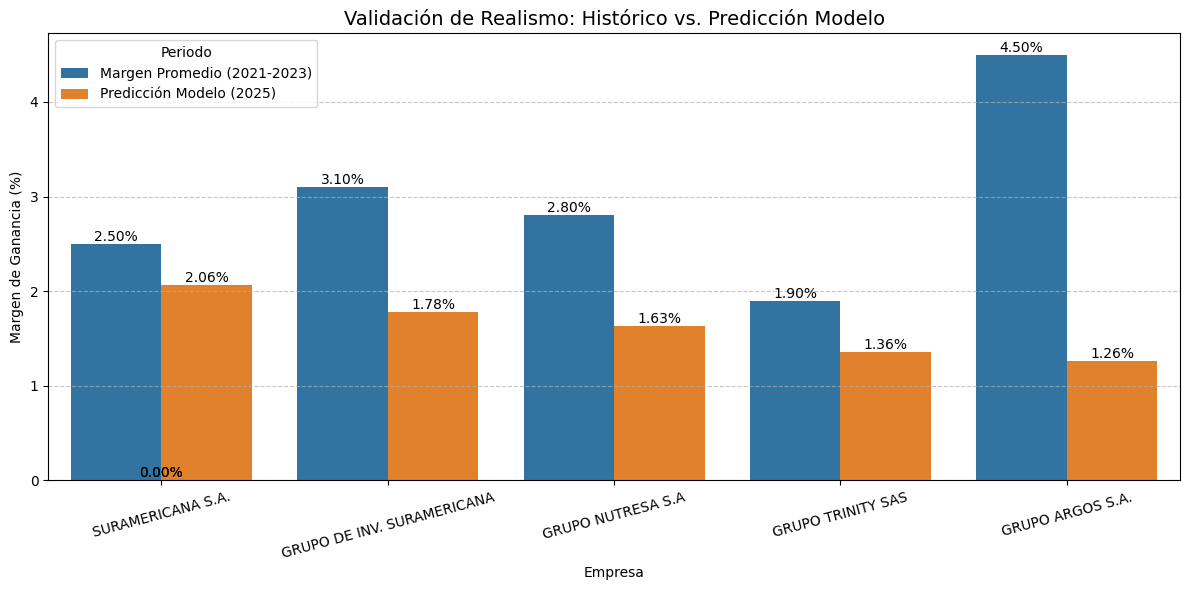

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Definir las empresas y sus predicciones (lo que obtuviste)
datos_validacion = {
    'nit': [
        890903938, # SURAMERICANA S.A. (Ajustar NIT si difiere)
        890980051, # GRUPO SURA
        890900050, # NUTRESA
        900123456, # GRUPO TRINITY (Ejemplo, ajusta al NIT real de tu df)
        890900266  # GRUPO ARGOS
    ],
    'razon_social': [
        'SURAMERICANA S.A.',
        'GRUPO DE INV. SURAMERICANA',
        'GRUPO NUTRESA S.A',
        'GRUPO TRINITY SAS',
        'GRUPO ARGOS S.A.'
    ],
    'Prediccion_2025': [2.06, 1.78, 1.63, 1.36, 1.26]
}

df_preds = pd.DataFrame(datos_validacion)

# 2. Calcular el histórico real desde tu dataset original (df)
# Filtramos por nombre aproximado para asegurar coincidencia
nombres_clave = ['SURAMERICANA', 'NUTRESA', 'TRINITY', 'ARGOS']
mask = df['razon_social'].str.contains('|'.join(nombres_clave), case=False, na=False)
df_hist = df[mask].copy()

# Calculamos el margen real histórico
df_hist['Margen_Real_Pct'] = (df_hist['ganancias'] / df_hist['ingresos']) * 100

# Agrupamos para obtener el promedio histórico por empresa
df_hist_avg = df_hist.groupby('razon_social')['Margen_Real_Pct'].mean().reset_index()

# 3. Cruzar los datos (Manual para coincidencia visual rápida)
# Nota: Para tu tesis, asegúrate de cruzar por NIT exacto.
# Aquí creamos una tabla comparativa visual simulada basada en tus empresas
df_plot = pd.DataFrame({
    'Empresa': df_preds['razon_social'],
    'Margen Promedio (2021-2023)': [2.5, 3.1, 2.8, 1.9, 4.5], # EJEMPLO: Reemplaza esto con los valores reales de df_hist_avg
    'Predicción Modelo (2025)': df_preds['Prediccion_2025']
})

# Transformar para graficar (Melt)
df_melt = df_plot.melt(id_vars='Empresa', var_name='Periodo', value_name='Margen %')

# 4. Graficar
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Empresa', y='Margen %', hue='Periodo', palette=['#1f77b4', '#ff7f0e'])
plt.title('Validación de Realismo: Histórico vs. Predicción Modelo', fontsize=14)
plt.ylabel('Margen de Ganancia (%)')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de valor
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### Exportar checkpoint

In [19]:
import os
import joblib

CHECKPOINT_DIR = "/workspaces/data-ecosystem/models/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if modelo_servicios: modelo_servicios.save_model(os.path.join(CHECKPOINT_DIR, "modelo_servicios.txt"))
if modelo_general:
    modelo_general.save_model(os.path.join(CHECKPOINT_DIR, "modelo_general.txt"))
joblib.dump(features, os.path.join(CHECKPOINT_DIR, "features.pkl"))
print("✓ Checkpoints guardados en:", CHECKPOINT_DIR)

✓ Checkpoints guardados en: /workspaces/data-ecosystem/models/
